In [ ]:
%cd ..

In [245]:
import pandas as pd
from pathlib import Path
from utils import remove_outliers_iqr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

## Load the data

In [133]:
data_folder = Path("data")
data_train = pd.read_csv(data_folder / "illinois_basing_train.csv")
data_test = pd.read_csv(data_folder / "illinois_basing_test.csv")
# Drop column Avg_PLT_CO2InjRate_TPH
data_train.drop(columns="Avg_PLT_CO2InjRate_TPH", inplace=True)

## Parse datetime

In [134]:
# %% Dates
data_train["SampleTimeUTC"] = pd.to_datetime(
    data_train["SampleTimeUTC"], format="%d/%m/%Y %H:%M"
)
data_test["SampleTimeUTC"] = pd.to_datetime(
    data_test["SampleTimeUTC"], format="%m/%d/%Y %H:%M"
)
# %% Set index
data_train.set_index("SampleTimeUTC", inplace=True)
data_test.set_index("SampleTimeUTC", inplace=True)

## Exploraty data analysis

### Plot the data

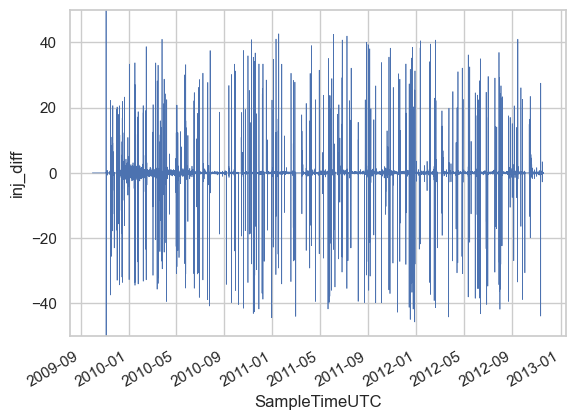

In [135]:
# %% Plot inj_diff column with time  using seaborn
sns.set()
sns.set_style("whitegrid")
sns.lineplot(x="SampleTimeUTC", y="inj_diff", data=data_train, linewidth=0.5)
plt.gcf().autofmt_xdate()
plt.ylim(-50, 50)
plt.show()

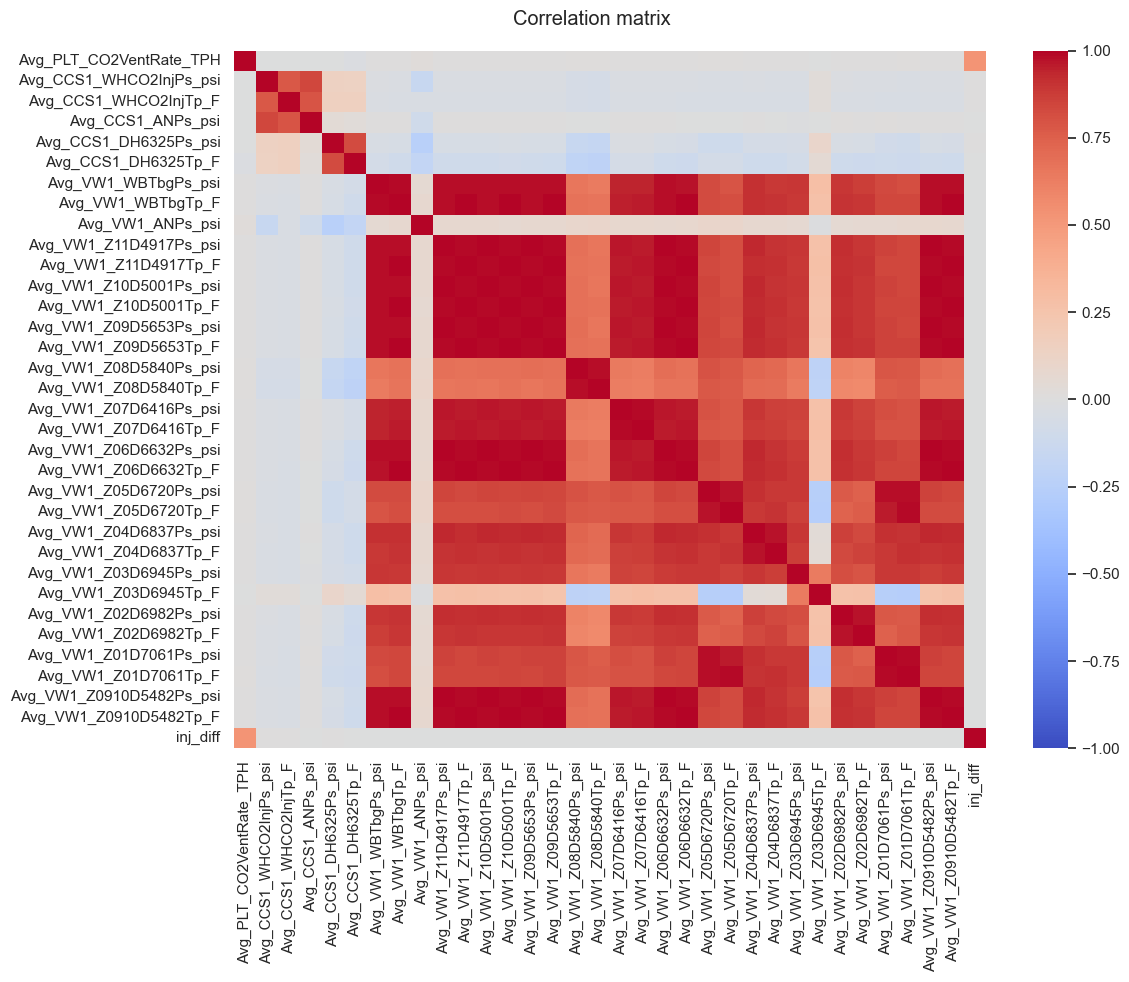

In [136]:
# %% Create a heatmap of the correlation matrix
corr = data_train.corr()
fig_1, ax_1 = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", ax=ax_1)
plt.suptitle("Correlation matrix")
plt.tight_layout()
plt.show()

Most of the information from the verification well seems to have multicolinearity, except for "Avg_VW1_ANPs_psi". This prelimanary conclusion makes sense since the all the other features are pressure and temperature data at different depths in the verification well. Let's include one single feature for the pressure and temperature of the verification well by taking the average of those features.

### Simplify data from VW1

In [137]:
cols_vw1 = [col for col in data_train.columns if "VW1" in col]
# Remove ["Avg_VW1_ANPs_psi", "Avg_VW1_WBTbgPs_psi", "Avg_VW1_WBTbgTp_F"] column
cols_vw1.remove("Avg_VW1_ANPs_psi")
cols_vw1.remove("Avg_VW1_WBTbgPs_psi")
cols_vw1.remove("Avg_VW1_WBTbgTp_F")
# Group columns by pressure and temperature
cols_vw1_pressure = [col for col in cols_vw1 if "_psi" in col]
cols_vw1_temperature = [col for col in cols_vw1 if "_F" in col]

In [138]:
# Create a new column with the average of the other columns for pressure and temperature
data_train["Avg_VW1_psi"] = data_train[cols_vw1_pressure].mean(axis=1)
data_train["Avg_VW1_F"] = data_train[cols_vw1_temperature].mean(axis=1)
data_test["Avg_VW1_psi"] = data_test[cols_vw1_pressure].mean(axis=1)
data_test["Avg_VW1_F"] = data_test[cols_vw1_temperature].mean(axis=1)
# Remove the other columns
data_train.drop(columns=cols_vw1, inplace=True)
data_test.drop(columns=cols_vw1, inplace=True)
# Reorder the columns so "inj_diff" is the last column
cols = data_train.columns.tolist()
cols.remove("inj_diff")
cols.append("inj_diff")
data_train = data_train[cols]

In [139]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27398 entries, 2009-10-01 00:00:00 to 2012-11-18 07:00:00
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Avg_PLT_CO2VentRate_TPH  27398 non-null  float64
 1   Avg_CCS1_WHCO2InjPs_psi  27270 non-null  float64
 2   Avg_CCS1_WHCO2InjTp_F    27398 non-null  float64
 3   Avg_CCS1_ANPs_psi        27304 non-null  float64
 4   Avg_CCS1_DH6325Ps_psi    27398 non-null  float64
 5   Avg_CCS1_DH6325Tp_F      27398 non-null  float64
 6   Avg_VW1_WBTbgPs_psi      26127 non-null  float64
 7   Avg_VW1_WBTbgTp_F        26061 non-null  float64
 8   Avg_VW1_ANPs_psi         23487 non-null  float64
 9   Avg_VW1_psi              26709 non-null  float64
 10  Avg_VW1_F                26709 non-null  float64
 11  inj_diff                 27397 non-null  float64
dtypes: float64(12)
memory usage: 2.7 MB


In [140]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201 entries, 2012-11-18 08:00:00 to 2012-11-26 16:00:00
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Avg_PLT_CO2VentRate_TPH  201 non-null    float64
 1   Avg_CCS1_WHCO2InjPs_psi  201 non-null    float64
 2   Avg_CCS1_WHCO2InjTp_F    201 non-null    float64
 3   Avg_CCS1_ANPs_psi        201 non-null    float64
 4   Avg_CCS1_DH6325Ps_psi    201 non-null    float64
 5   Avg_CCS1_DH6325Tp_F      201 non-null    float64
 6   Avg_VW1_WBTbgPs_psi      201 non-null    float64
 7   Avg_VW1_WBTbgTp_F        201 non-null    float64
 8   Avg_VW1_ANPs_psi         197 non-null    float64
 9   Avg_VW1_psi              201 non-null    float64
 10  Avg_VW1_F                201 non-null    float64
dtypes: float64(11)
memory usage: 18.8 KB


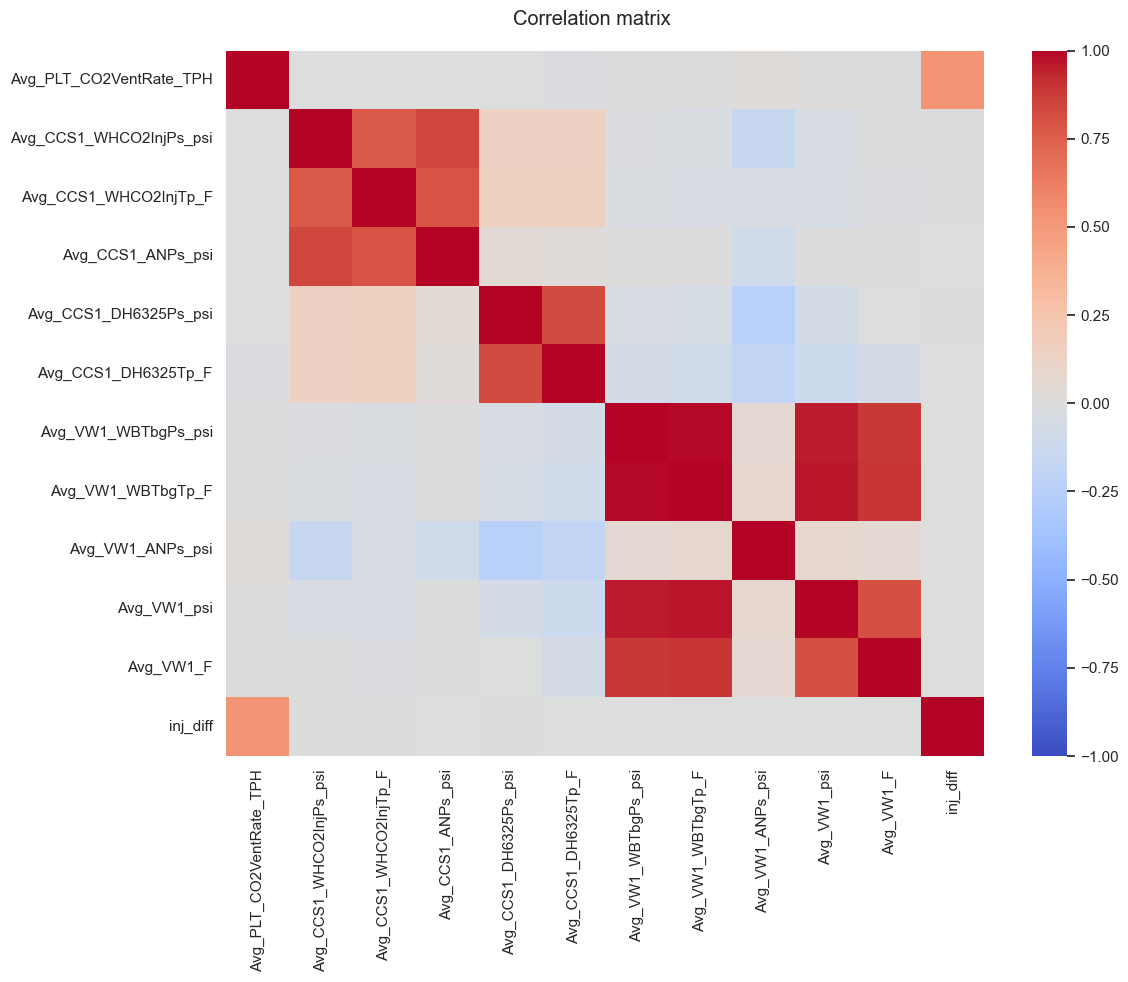

In [141]:
# Plot correlation matrix again
corr = data_train.corr()
fig_1, ax_1 = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", ax=ax_1)
plt.suptitle("Correlation matrix")
plt.tight_layout()
plt.show()

### Plot time series

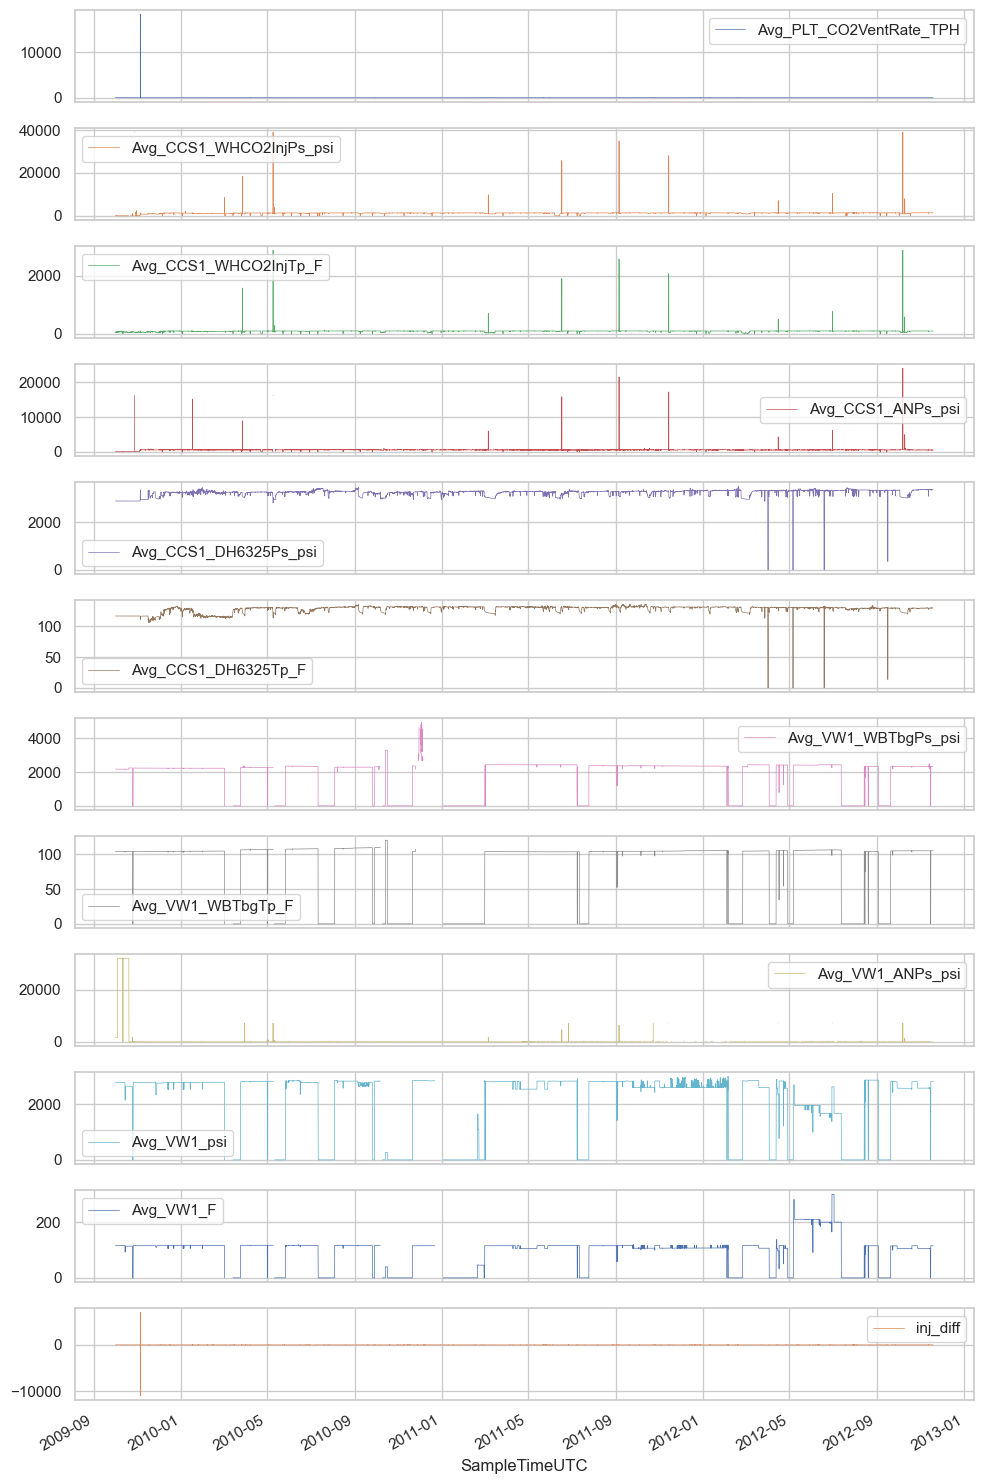

In [142]:
data_train.plot(linewidth=0.5, subplots=True, figsize=(10, 15))
plt.tight_layout()
plt.show()

The time-series plots show some outliers that had occurred around the same time. This might be due to a malfunction of the sensor in the injector well CCS1. Before removing the outliers, let's get some statistics on the data.

In [143]:
data_train.describe()

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_psi,Avg_VW1_F,inj_diff
count,27398.000000,27270.000000,27398.000000,27304.000000,27398.000000,27398.000000,26127.000000,26061.000000,23487.000000,26709.000000,26709.000000,27397.000000
mean,2.122022,1239.861825,89.766221,560.862134,3244.168246,127.738740,1801.844864,80.794406,525.000311,2071.745859,93.989454,0.001651
std,133.162146,817.740091,48.287324,445.931405,173.471253,7.167508,999.374082,44.286916,3988.707539,1152.055816,55.660776,82.690245
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-11021.132640
25%,0.000000,1235.469308,92.953925,523.536663,3233.023426,127.166621,2173.526853,103.423346,0.452148,1675.003471,105.496756,-0.072917
50%,0.058333,1338.872024,96.268226,564.901591,3286.067870,130.109008,2322.382139,104.196940,4.656250,2770.389960,115.397683,0.000000
75%,0.150000,1361.045834,96.851236,604.763645,3324.735273,131.082033,2379.839354,105.044018,16.900514,2821.062193,116.161374,0.074305
max,18333.150000,39032.410160,2879.416016,24105.630860,3515.880615,135.670399,4954.731745,120.056561,31993.509770,3011.052469,300.310345,7033.459028


From the line plots and summary statistics it is clear that we have some outliers that are not representative of the data. Let's remove the outliers using the interquartile range (IQR) method.

### Remove outliers
We first remove the outliers that have exaggerated values by using a high IQR multiplier.

In [144]:
data_train_clean = data_train.copy()

iqr_mult_high = 300
iqr_mult_med = 10
cols_high = ["Avg_PLT_CO2VentRate_TPH", "inj_diff", "Avg_VW1_WBTbgPs_psi", "Avg_VW1_WBTbgTp_F"]
cols_med = [col for col in data_train_clean.columns if col not in cols_high]
for col in cols_high:
    data_train_clean[col], _, _ = remove_outliers_iqr(data_train_clean[col], iqr_mult_high)

for col in cols_med:
    data_train_clean[col], _, _ = remove_outliers_iqr(data_train_clean[col], iqr_mult_med)

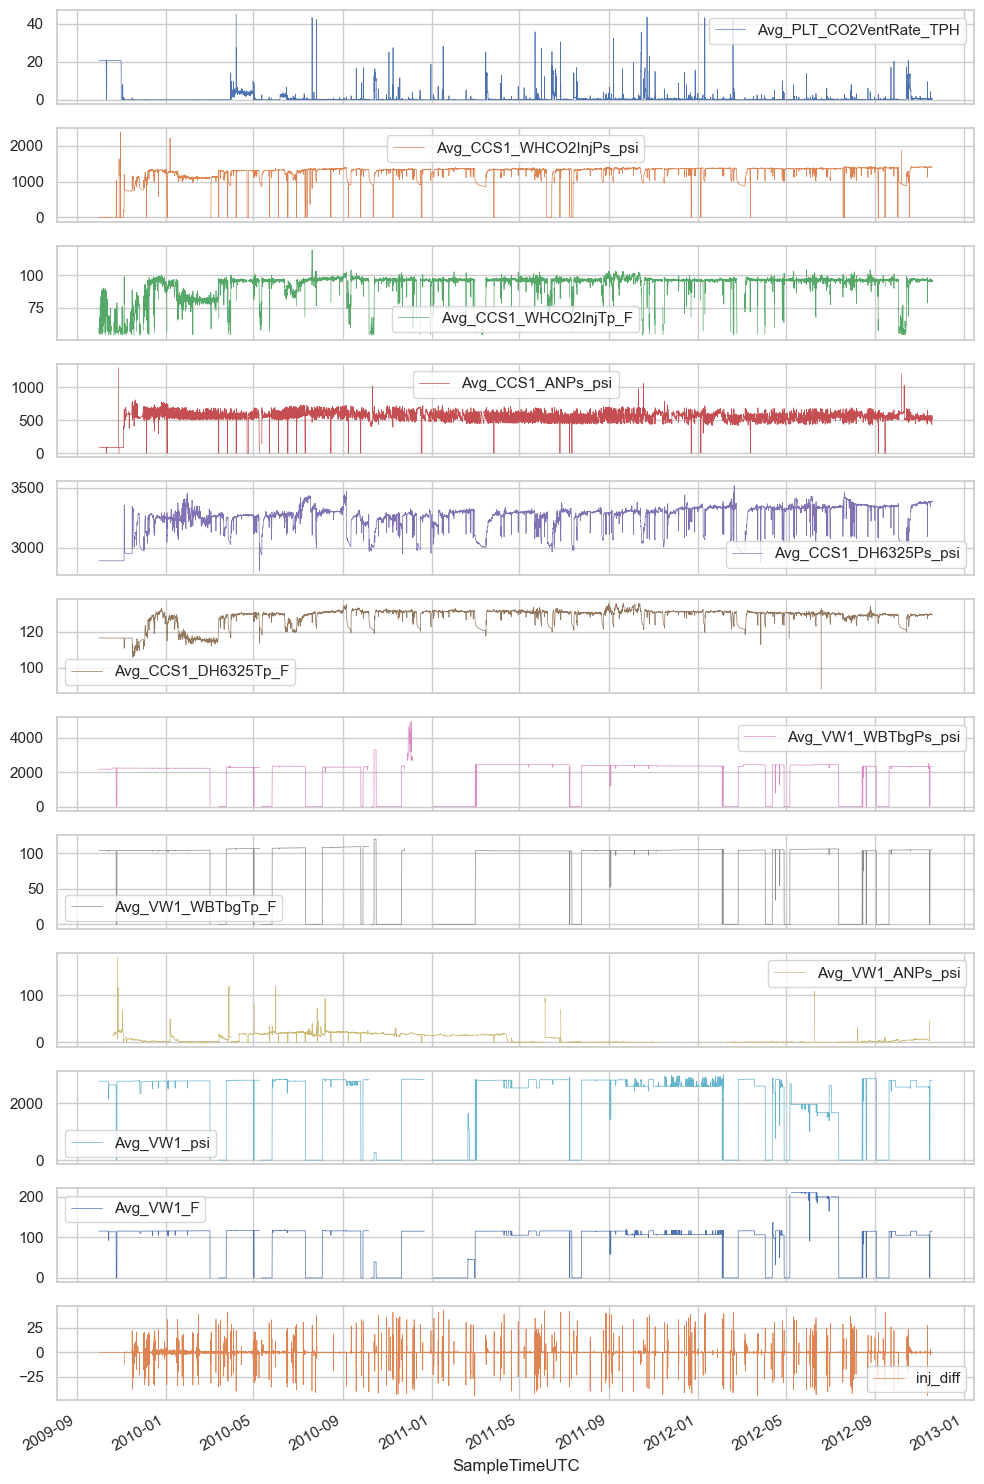

In [145]:
# Plot the data again
data_train_clean.plot(linewidth=0.5, subplots=True, figsize=(10, 15))
plt.tight_layout()
plt.show()

In [146]:
# Calculate the missing values ratio for each column accounting only for the outliers removal
missing_values_out = (data_train_clean.isna().sum() - data_train.isna().sum()) / data_train.count()
missing_values_out.sort_values(ascending=False, inplace=True)
print("Missing values ratio due to outlier removal:")
missing_values_out

Missing values ratio due to outlier removal:


Avg_CCS1_WHCO2InjTp_F      0.074640
Avg_VW1_ANPs_psi           0.021586
Avg_VW1_F                  0.004343
Avg_CCS1_DH6325Ps_psi      0.001642
Avg_CCS1_DH6325Tp_F        0.001606
Avg_CCS1_WHCO2InjPs_psi    0.000990
Avg_CCS1_ANPs_psi          0.000989
inj_diff                   0.000219
Avg_PLT_CO2VentRate_TPH    0.000219
Avg_VW1_WBTbgPs_psi        0.000000
Avg_VW1_WBTbgTp_F          0.000000
Avg_VW1_psi                0.000000
dtype: float64

In [147]:
# Missing values ratio total
missing_values_tot = (data_train_clean.isna().sum()) / data_train.count()
missing_values_tot.sort_values(ascending=False, inplace=True)
print("Missing values ratio due to outlier removal:")
missing_values_tot

Missing values ratio due to outlier removal:


Avg_VW1_ANPs_psi           0.188104
Avg_CCS1_WHCO2InjTp_F      0.074640
Avg_VW1_WBTbgTp_F          0.051303
Avg_VW1_WBTbgPs_psi        0.048647
Avg_VW1_F                  0.030140
Avg_VW1_psi                0.025797
Avg_CCS1_WHCO2InjPs_psi    0.005684
Avg_CCS1_ANPs_psi          0.004432
Avg_CCS1_DH6325Ps_psi      0.001642
Avg_CCS1_DH6325Tp_F        0.001606
inj_diff                   0.000256
Avg_PLT_CO2VentRate_TPH    0.000219
dtype: float64

### Impute missing values
We will do this with backward-fill for now.

In [152]:
# %% back-fill missing values for each column
data_train_clean = data_train_clean.fillna(method="bfill")
data_test_clean = data_test.fillna(method="bfill")

In [153]:
data_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27398 entries, 2009-10-01 00:00:00 to 2012-11-18 07:00:00
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Avg_PLT_CO2VentRate_TPH  27398 non-null  float64
 1   Avg_CCS1_WHCO2InjPs_psi  27398 non-null  float64
 2   Avg_CCS1_WHCO2InjTp_F    27398 non-null  float64
 3   Avg_CCS1_ANPs_psi        27398 non-null  float64
 4   Avg_CCS1_DH6325Ps_psi    27398 non-null  float64
 5   Avg_CCS1_DH6325Tp_F      27398 non-null  float64
 6   Avg_VW1_WBTbgPs_psi      27398 non-null  float64
 7   Avg_VW1_WBTbgTp_F        27398 non-null  float64
 8   Avg_VW1_ANPs_psi         27398 non-null  float64
 9   Avg_VW1_psi              27398 non-null  float64
 10  Avg_VW1_F                27398 non-null  float64
 11  inj_diff                 27398 non-null  float64
dtypes: float64(12)
memory usage: 2.7 MB


In [154]:
data_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201 entries, 2012-11-18 08:00:00 to 2012-11-26 16:00:00
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Avg_PLT_CO2VentRate_TPH  201 non-null    float64
 1   Avg_CCS1_WHCO2InjPs_psi  201 non-null    float64
 2   Avg_CCS1_WHCO2InjTp_F    201 non-null    float64
 3   Avg_CCS1_ANPs_psi        201 non-null    float64
 4   Avg_CCS1_DH6325Ps_psi    201 non-null    float64
 5   Avg_CCS1_DH6325Tp_F      201 non-null    float64
 6   Avg_VW1_WBTbgPs_psi      201 non-null    float64
 7   Avg_VW1_WBTbgTp_F        201 non-null    float64
 8   Avg_VW1_ANPs_psi         201 non-null    float64
 9   Avg_VW1_psi              201 non-null    float64
 10  Avg_VW1_F                201 non-null    float64
dtypes: float64(11)
memory usage: 18.8 KB


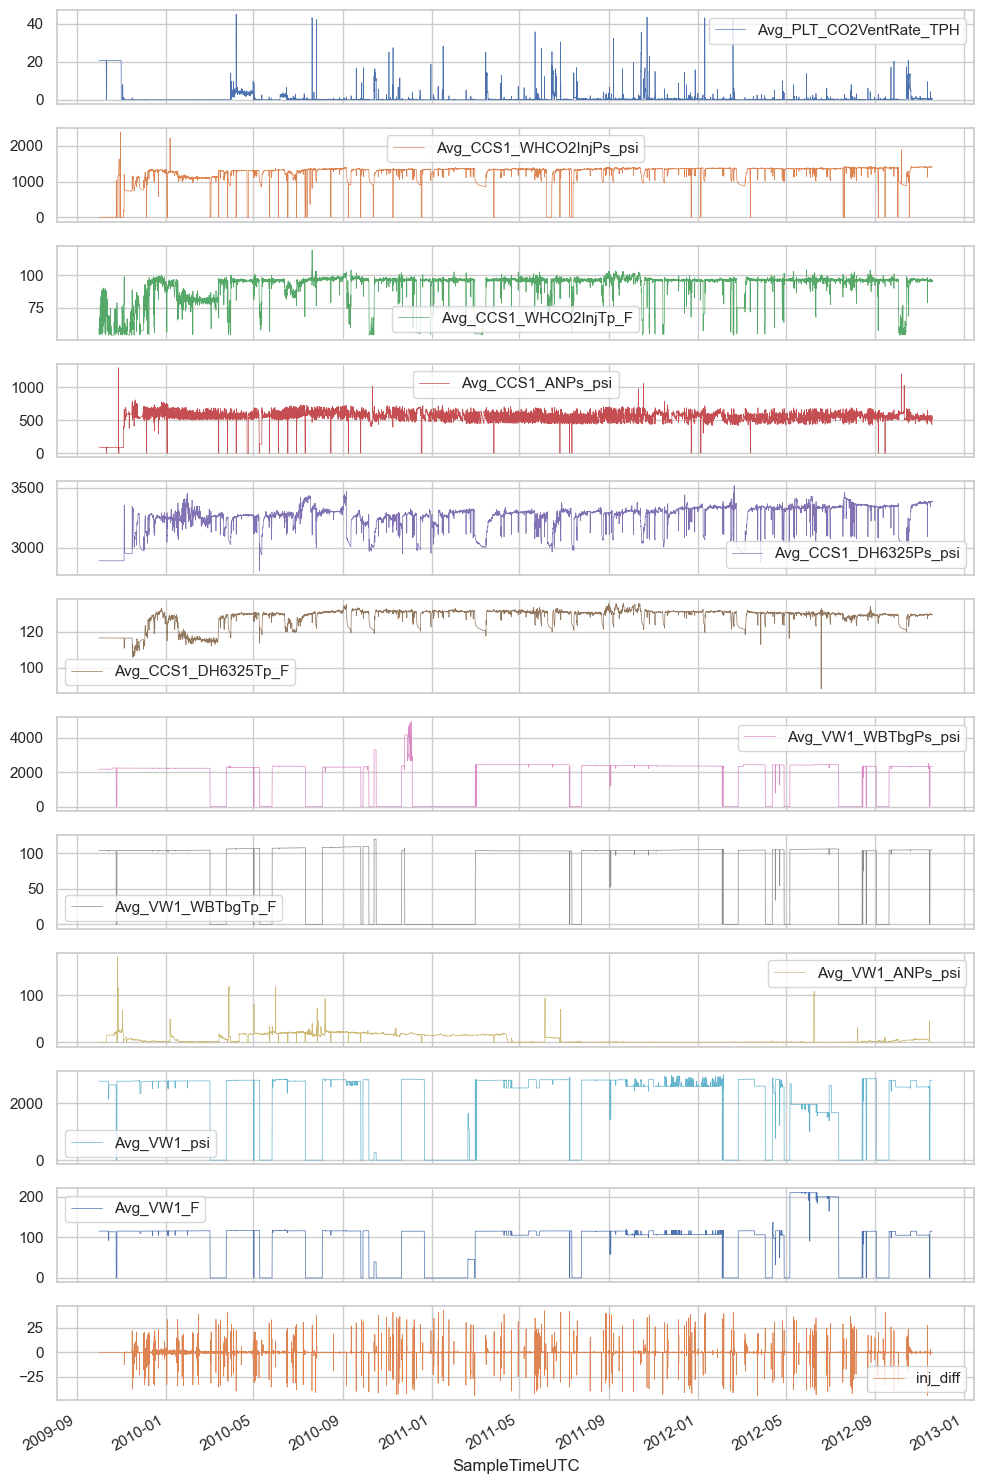

In [150]:
data_train_clean.plot(linewidth=0.5, subplots=True, figsize=(10, 15))
plt.tight_layout()
plt.show()

Let's get the summary statistics again.

In [155]:
data_train_clean.describe()

,Avg_PLT_CO2VentRate_TPH,Avg_CCS1_WHCO2InjPs_psi,Avg_CCS1_WHCO2InjTp_F,Avg_CCS1_ANPs_psi,Avg_CCS1_DH6325Ps_psi,Avg_CCS1_DH6325Tp_F,Avg_VW1_WBTbgPs_psi,Avg_VW1_WBTbgTp_F,Avg_VW1_ANPs_psi,Avg_VW1_psi,Avg_VW1_F,inj_diff
count,27398.000000,27398.000000,27398.000000,27398.000000,27398.000000,27398.000000,27398.000000,27398.000000,27398.000000,27398.000000,27398.000000,27398.000000
mean,1.001962,1216.616900,91.145751,547.738991,3249.434095,127.942959,1744.082605,76.851705,7.519540,2019.645965,91.250190,0.005095
std,3.873320,310.150501,11.551103,115.669551,117.625711,5.119732,1052.935620,46.568557,10.654845,1182.827780,55.843993,3.746273
min,0.000000,0.000000,54.006020,0.000000,2809.975412,88.385506,0.000000,0.000000,0.000000,0.000000,0.000000,-44.149653
25%,0.000000,1229.527108,93.435951,522.977463,3233.933933,127.222147,0.000000,0.000000,0.210449,1527.626477,97.019954,-0.072917
50%,0.058333,1338.584063,96.270972,564.616482,3286.285073,130.116883,2322.240098,104.148701,1.420776,2720.391904,115.385892,0.000000
75%,0.150000,1360.893250,96.848946,604.537241,3325.160079,131.082620,2378.734264,105.010891,15.654251,2820.922757,116.138564,0.074305
max,44.933333,2380.935305,119.668026,1296.115902,3515.880615,135.670399,4954.731745,120.056561,181.247326,3011.052469,210.537481,42.592708


### Preliminary findings
It seems the inj_diff response has two types of outliers. The first type is the ones that we have already removed. The second type is the ones that are not extreme but are still not representative of the data. The latter could be events where the injection well exhibit some type of leaks or malfunction, which is something we are interested in modeling. Let's analyze the data further but this time separating the data into two groups: the ones that have a high abs(inj_diff) and the ones that have a low abs(inj_diff).

### Separate data into two groups (outliers and normal)

In [ ]:
inj_diff_normal, lb_norm, up_norm = remove_outliers_iqr(data_train_clean["inj_diff"], 10)
# Label the outliers in dat_train_clean using the lb_norm and up_norm boundaries
outlier_condition = (data_train_clean["inj_diff"] < lb_norm) | (data_train_clean["inj_diff"] > up_norm)
data_train_clean["outlier_label"] = 0
data_train_clean.loc[outlier_condition, "outlier_label"] = 1
inj_diff_outliers = data_train_clean.loc[outlier_condition, "inj_diff"]
# Print the ratio of outliers
print(f"Ratio of outliers: {len(inj_diff_outliers) / len(data_train_clean):.2f}")

### Perform EDA of the two groups

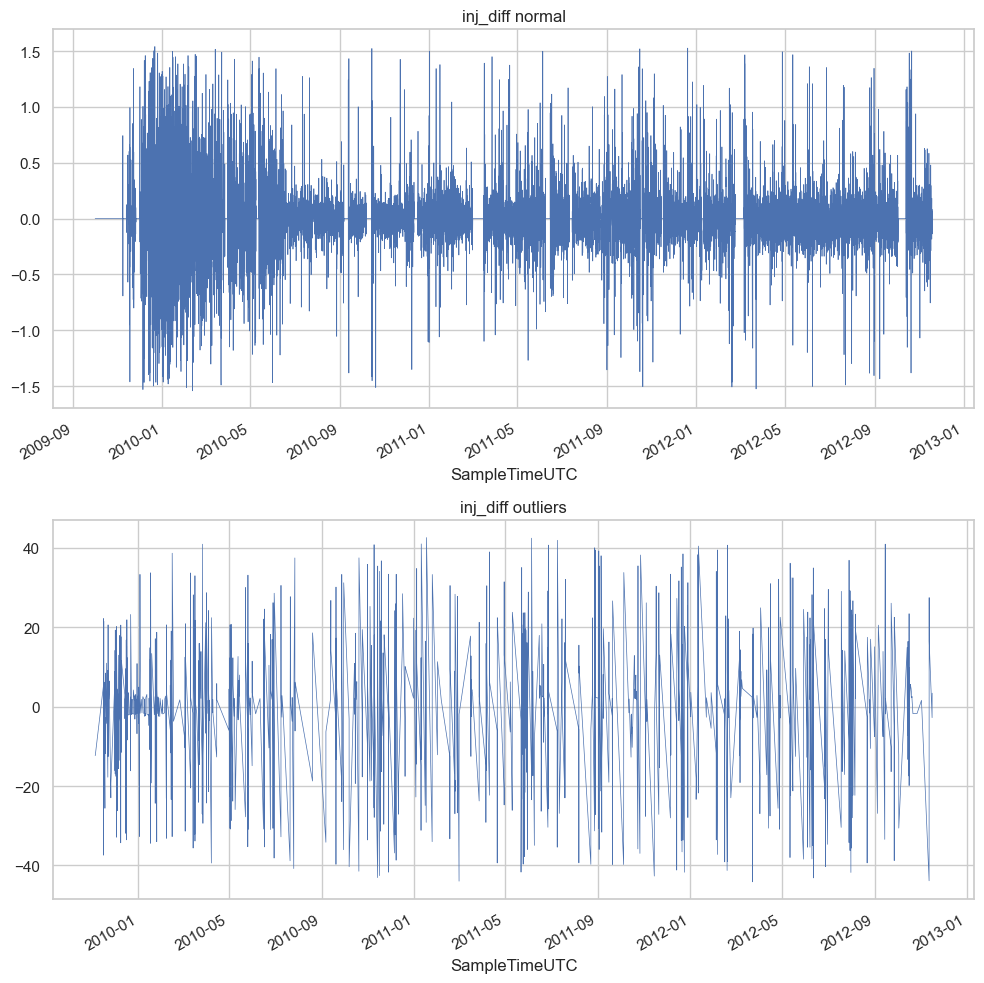

In [168]:
# Plot the data again the inj_diff normal and outliers
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
inj_diff_normal.plot(linewidth=0.5, ax=ax[0])
ax[0].set_title("inj_diff normal")
inj_diff_outliers.plot(linewidth=0.5, ax=ax[1])
ax[1].set_title("inj_diff outliers")
plt.tight_layout()
plt.show()

### Create two separate training sets for the two groups

In [171]:
df_train_normal = data_train_clean.loc[data_train_clean["outlier_label"] == 0, :].drop("outlier_label", axis=1)
df_train_outliers = data_train_clean.loc[data_train_clean["outlier_label"] == 1, :].drop("outlier_label", axis=1)

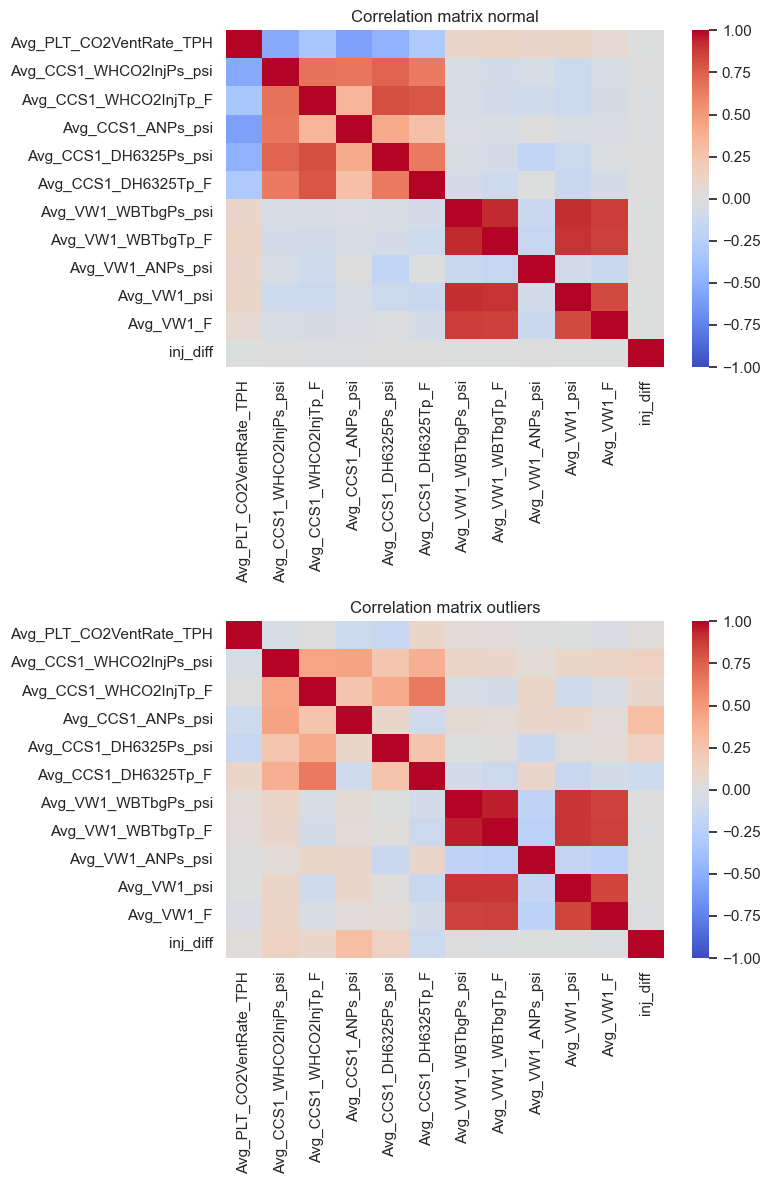

In [173]:
# Plot the correlation matrix of the two groups
corr_normal = df_train_normal.corr()
corr_outliers = df_train_outliers.corr()
fig, ax = plt.subplots(2, 1, figsize=(8, 12))
sns.heatmap(corr_normal, vmin=-1, vmax=1, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Correlation matrix normal")
sns.heatmap(corr_outliers, vmin=-1, vmax=1, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Correlation matrix outliers")
plt.tight_layout()
plt.show()

## Analyze the normal group as a time-series problem
Let's analyze the normal group as a time-series problem since it has most of the information we will require to model and there might be a degree of autocorrelation, trend and seasonality in the data.

### Resample the normal group to hourly frequency
We need to resample the normal data to hourly again since we have removed some outliers. We fill the nan by interpolation.

In [176]:
start_date = data_train_clean.index[0]
end_date = data_train_clean.index[-1]
df_train_normal = df_train_normal.resample("H").interpolate()

In [ ]:
# Print the original start and end dates
print(f"Original start date: {start_date}")
print(f"Original end date: {end_date}")
df_train_normal.info()

### Decompose the normal group into trend, seasonality and residuals

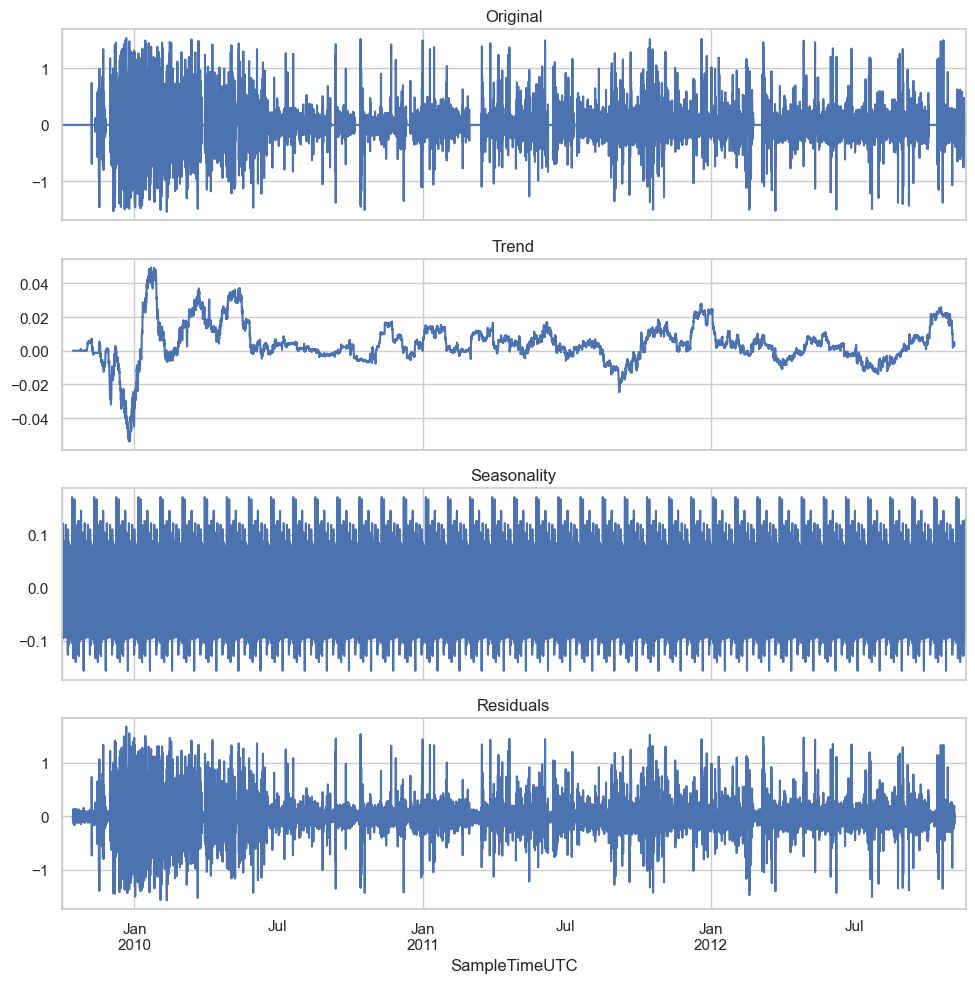

In [191]:
# Decompose the normal group into trend, seasonality and residuals
decomposition = seasonal_decompose(df_train_normal["inj_diff"], model="additive", period=24 * 7 * 4)
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
df_train_normal["inj_diff"].plot(ax=ax[0])
ax[0].set_title("Original")
decomposition.trend.plot(ax=ax[1])
ax[1].set_title("Trend")
decomposition.seasonal.plot(ax=ax[2])
ax[2].set_title("Seasonality")
decomposition.resid.plot(ax=ax[3])
ax[3].set_title("Residuals")
plt.tight_layout()
plt.show()

In [193]:
# Calculate difference between consecutive values
D = pm.arima.utils.nsdiffs(
    df_train_normal["inj_diff"], m=24, max_D=24, test="ch"
)
print(f"Number of non-seasonal differences: {D}")

Number of non-seasonal differences: 1


C:\Users\OGomez3\Miniconda3\envs\ml-ch-2023\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


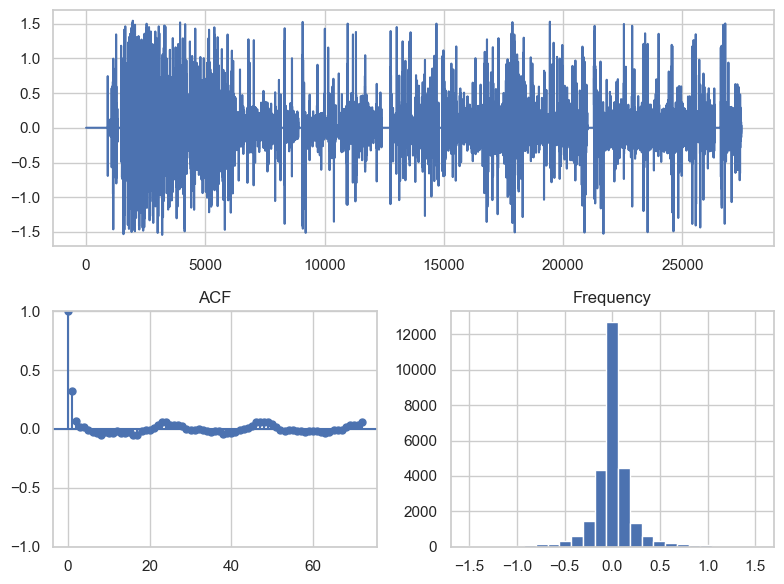

In [197]:
pm.tsdisplay(df_train_normal["inj_diff"], lag_max=72)

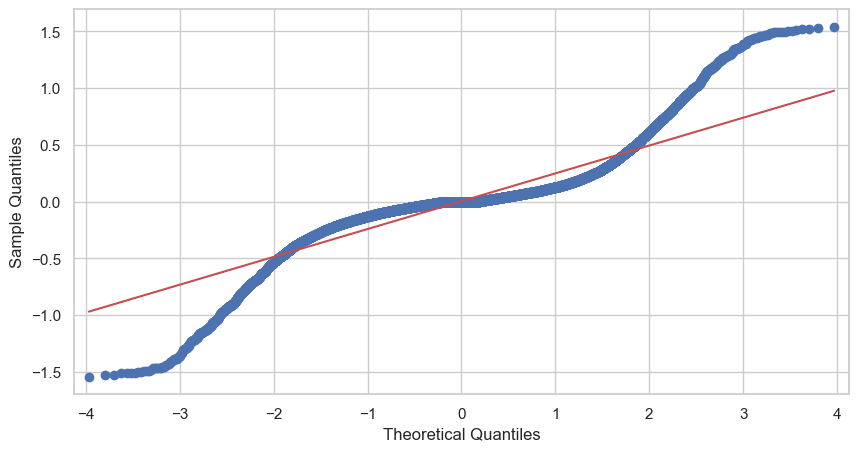

In [199]:
# Plot the Q-Q plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sm.qqplot(df_train_normal["inj_diff"], line="s", ax=ax)
plt.show()

The normality assumption does not seem to hold, but we will proceed with the modeling to test its performance.

### Train ARIMA model

In [ ]:
cols_exclude_normal = ['Avg_VW1_WBTbgPs_psi', 'Avg_VW1_WBTbgTp_F', 'Avg_VW1_ANPs_psi', 'Avg_VW1_psi', 'Avg_VW1_F']
df_train_normal = df_train_normal.drop(cols_exclude_normal, axis=1)

In [239]:
df_train_normal_cut = df_train_normal.loc["2012-03-01":]

In [240]:
# Use auto_arima to find the best ARIMA model
model_auto = pm.auto_arima(
    df_train_normal_cut["inj_diff"],
    X=df_train_normal_cut.drop("inj_diff", axis=1),
    start_p=0,
    start_q=0,
    m=24,
    start_P=0,
    seasonal=True,
    D=D,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [228]:
model_normal = pm.ARIMA(
    order=(2, 1, 1),
    seasonal_order=(0, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

In [229]:
model_normal.fit(df_train_normal_cut["inj_diff"], df_train_normal_cut.drop("inj_diff", axis=1))

ARIMA(order=(2, 1, 1), seasonal_order=(0, 1, 1, 24))

In [230]:
model_normal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                12872
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 24)   Log Likelihood                2925.027
Date:                            Sun, 23 Apr 2023   AIC                          -5826.054
Time:                                    15:46:13   BIC                          -5736.548
Sample:                                06-01-2011   HQIC                         -5796.127
                                     - 11-18-2012                                         
Covariance Type:                              opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept               -4.935e-06   2.25e-06     -2.189      0.029   -9.35e-06   -5.16e-07
Avg_PLT_CO2VentRate_TPH     0.0007      0.000      1.507      0.132      -0.000       0.002
Avg_CCS1_WHCO2InjPs_psi  2.592e-05   1.45e-05      1.791      0.073   -2.44e-06    5.43e-05
Avg_CCS1_WHCO2InjTp_F      -0.0042      0.000     -9.354      0.000      -0.005      -0.003
Avg_CCS1_ANPs_psi        -3.48e-05   3.66e-05     -0.952      0.341      -0.000    3.69e-05
Avg_CCS1_DH6325Ps_psi      -0.0003   5.25e-05     -5.547      0.000      -0.000      -0.000
Avg_CCS1_DH6325Tp_F         0.0245      0.001     29.297      0.000       0.023       0.026
ar.L1                       0.1681      0.004     40.129      0.000       0.160       0.176
ar.L2                      -0.0948      0.005    -17.933      0.000      -0.105      -0.084
ma.L1                      -0.9536      0.002   -429.801      0.000      -0.958      -0.949
ma.S.L24                   -0.9757      0.002   -461.741      0.000      -0.980      -0.972
sigma2                      0.0371      0.000    216.945      0.000       0.037       0.037
===================================================================================
Ljung-Box (L1) (Q):                 176.94   Jarque-Bera (JB):            102992.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

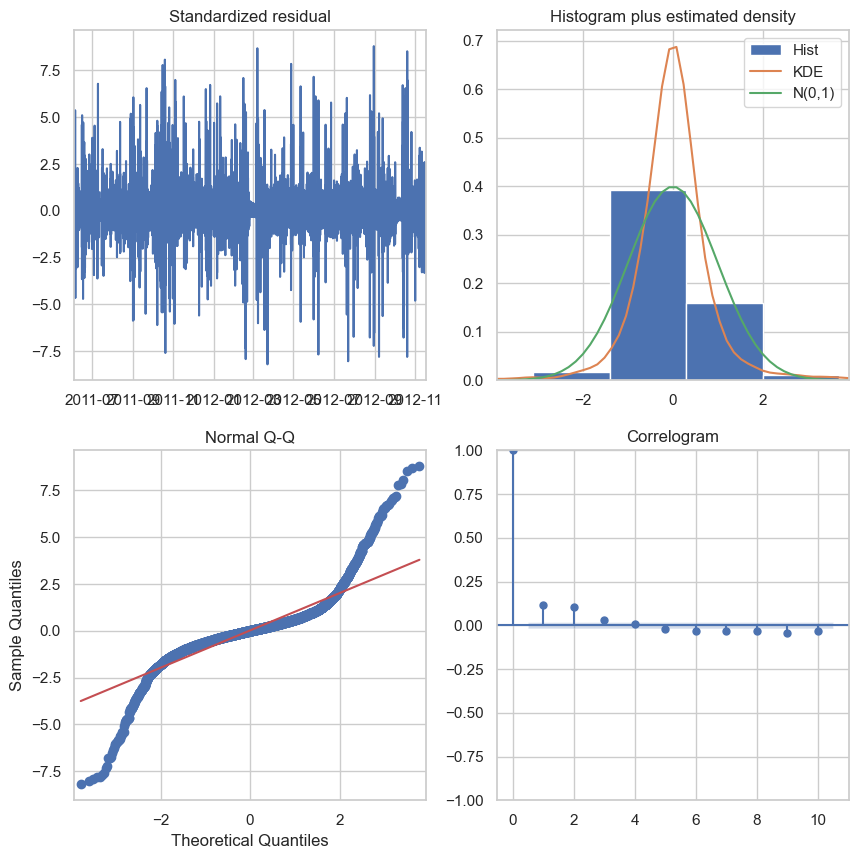

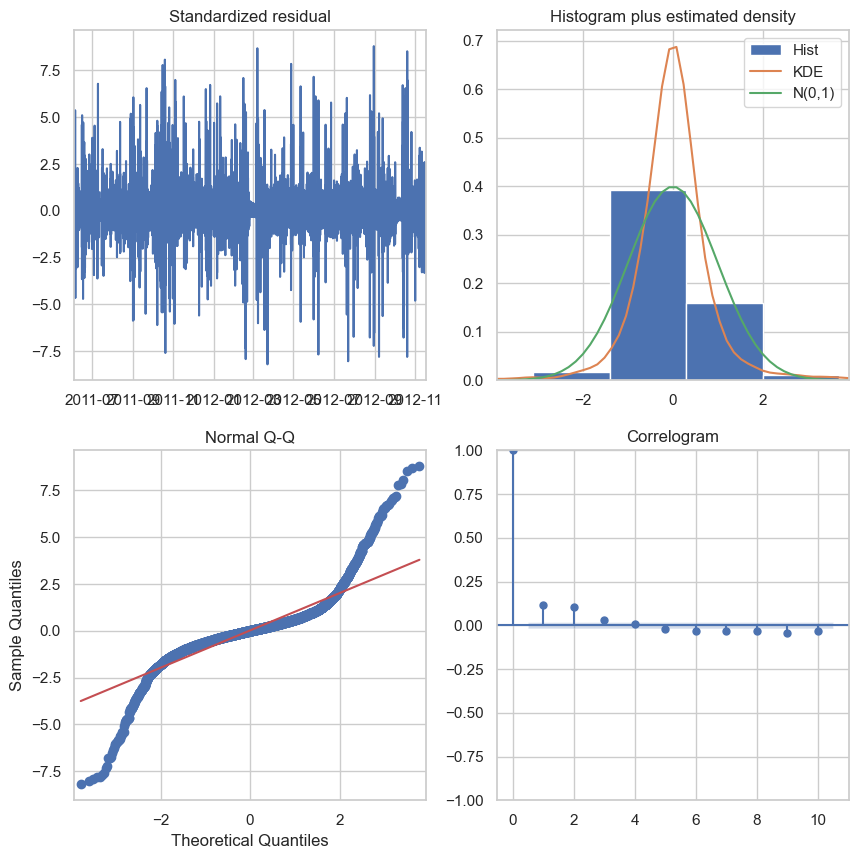

In [231]:
# Plot the diagnostics
model_normal.plot_diagnostics(figsize=(10, 10))

In [232]:
pred = model_normal.predict(n_periods=len(data_test_clean), X=data_test_clean.drop(cols_exclude_normal, axis=1))

In [233]:
y_test = pd.read_csv("data/illinois_basing_test_original.csv")
y_test = y_test["inj_diff_Calculated"]

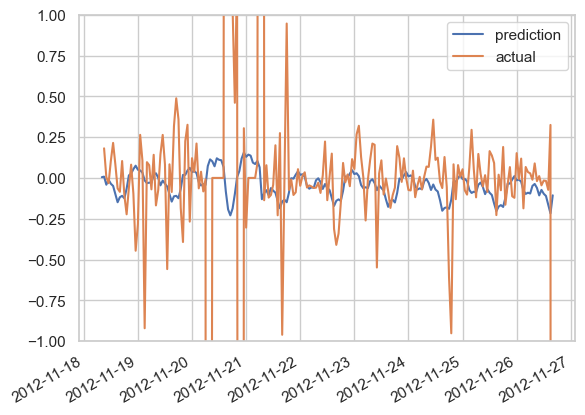

In [237]:
plt.plot(data_test_clean.index, pred, label="prediction")
plt.plot(data_test_clean.index, y_test, label="actual")
plt.gcf().autofmt_xdate()
plt.ylim(-1, 1)
plt.legend()
plt.show()

In [244]:
rmse_normal = np.sqrt(mean_squared_error(y_test[1:], pred[1:]))
print(f"RMSE: {rmse_normal:.2f}")

RMSE: 5.57
